In [1]:
import torch
import torch.nn as nn

In [2]:
# DINOv2
model: nn.Module = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

Using cache found in C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


(1920, 1080)


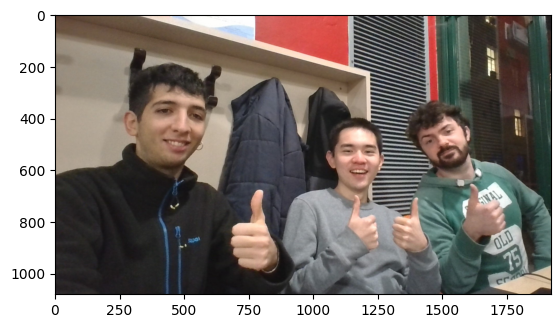

torch.Size([1, 3, 420, 420])


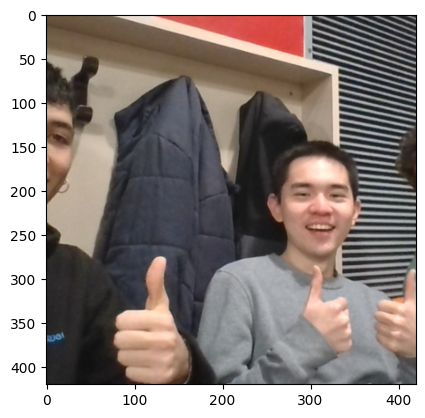

In [3]:
# Open a sample image from ImageNet
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

input_image = Image.open("test2.jpg")

# Preprocess the image
preprocess = transforms.Compose(
    [
        transforms.Resize(512),
        transforms.CenterCrop(14 * 30),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)
print(input_image.size)
plt.imshow(input_image)
plt.show()
x = preprocess(input_image).unsqueeze(0)
print(x.shape)
plt.imshow(x[0].permute(1, 2, 0))
plt.show()
y = model(x)

In [4]:
model

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [5]:
model: nn.Module = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

x = preprocess(input_image).unsqueeze(0)


y = model(x, is_training=True)


y = y["x_norm_patchtokens"]


B, num_patches, d_model = y.shape


print(y.shape)

_, _, H, W = x.shape
print(H * W / (14 * 14))

Using cache found in C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main


torch.Size([1, 900, 384])
900.0


(900, 3)


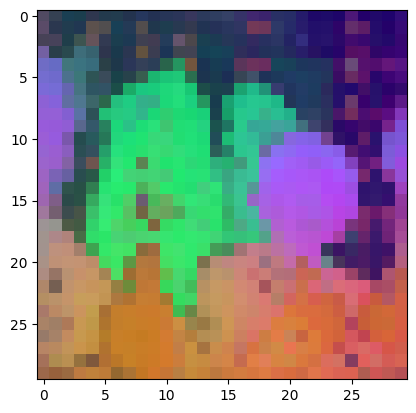

In [6]:
# Apply PCA to the last dimension of y
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm

pca = PCA(n_components=3)
H, W = 30, 30
result_image = np.zeros((H, W, 3))
# for n in tqdm(range(num_patches)):
patch_color = pca.fit_transform(y[0].detach().numpy())
patch_color = (patch_color - patch_color.min()) / (
    patch_color.max() - patch_color.min()
)
print(patch_color.shape)

for i in range(H):
    for j in range(W):
        n = i * H + j
        result_image[i, j] = patch_color[n]

result_image = result_image.reshape(H, W, 3)
plt.imshow(result_image)

In [102]:
class DINOv2_SemanticSegmentation(nn.Module):
    def __init__(self, num_classes, image_size):
        super().__init__()
        self.num_classes = num_classes

        self.feature_extractor = torch.hub.load(
            "facebookresearch/dinov2", "dinov2_vits14"
        )

        self.head = SegmentationHead(num_classes, 384, image_size)

    def forward(self, x):
        y = self.feature_extractor(x, is_training=True)
        features = y["x_norm_patchtokens"]

        B, HW, d_model = features.shape
        features = features.view((B, int(np.sqrt(HW)), int(np.sqrt(HW)), d_model))
        features = torch.permute(features, (0, 3, 1, 2))

        return self.head(features)


class SegmentationHead(nn.Module):
    def __init__(self, num_classes, d_model, image_size):
        super().__init__()
        self.num_classes = num_classes

        self.l1 = nn.Linear(d_model, 512)
        self.up = nn.Upsample((image_size, image_size))
        self.out = nn.Conv2d(
            512,
            num_classes,
            kernel_size=3,
            stride=1,
            padding="same",
            padding_mode="reflect",
        )

    def forward(self, x):
        B, d_model, H, W = x.shape
        x = torch.permute(x, (0, 3, 2, 1))
        # x.shape = (B, H, W, d_model)
        x = self.l1(x)
        # x.shape = (B, H, W, 512)
        x = torch.permute(x, (0, 3, 2, 1))
        # x.shape = (B, 512, H, W)
        x = self.up(x)
        # x.shape = (B, 512, image_size, image_size)
        x = self.out(x)
        # x.shape = (B, num_classes, image_size, image_size)
        return x

In [103]:
model = DINOv2_SemanticSegmentation(13, 14 * 30)
x = preprocess(input_image).unsqueeze(0)
print(x.shape)
y = model(x)
print(y.shape)

Using cache found in C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main


torch.Size([1, 3, 420, 420])
torch.Size([1, 13, 420, 420])


Using cache found in C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main
  0%|          | 0/2 [00:00<?, ?it/s]

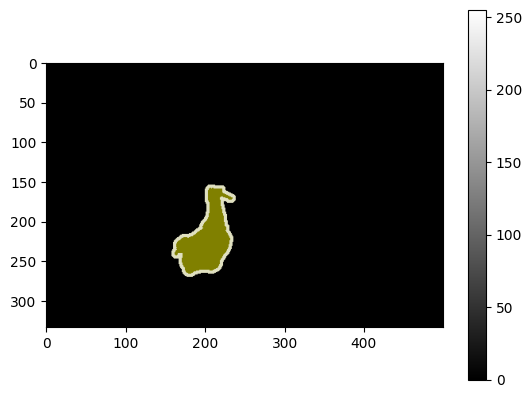

[  0 113 220]
[  0 113 220]
[  0 147 220]
[  0 147 220]
[  0 133 147 220]
[  0 133 147 220]
[  0 147 220]
[  0 147 220]


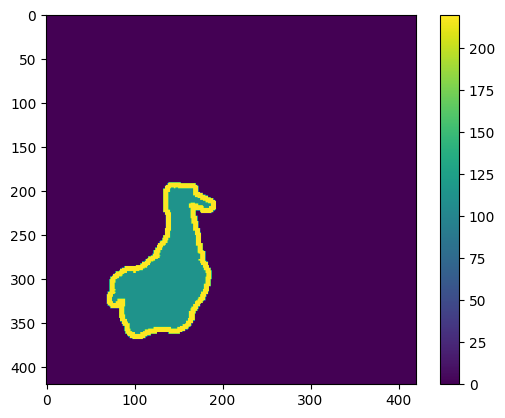

  0%|          | 0/2 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Train the model for a simple semantic segmentation task using the Pascal VOC
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

train_dataset = VOCSegmentation(
    root="data",
    year="2012",
    image_set="train",
    # download=True,
    # transform=transforms.ToTensor(),
)


def preprocess_image(img):
    return transforms.Compose(
        [
            transforms.Resize(512),  # Resize image
            transforms.CenterCrop(14 * 30),  # Crop image
            transforms.ToTensor(),  # Convert to tensor
        ]
    )(img)


def preprocess_mask(mask):
    mask = mask.convert("L")  # Convert to grayscale
    # print(np.unique(np.array(mask)))
    out = transforms.Compose(
        [
            transforms.Resize(
                512, interpolation=Image.NEAREST
            ),  # Nearest neighbor for masks
            transforms.CenterCrop(14 * 30),  # Crop mask
            # transforms.ToTensor(),  # Convert to tensor (no normalization)
        ]
    )(mask)
    out = torch.tensor(np.array(out))
    # print(np.unique(out))
    return out


def custom_collate(batch):
    x, y = zip(*batch)
    x = [preprocess_image(img) for img in x]
    y = [preprocess_mask(img) for img in y]

    return torch.stack(x), torch.stack(y)


train_loader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate
)

model = DINOv2_SemanticSegmentation(21, 14 * 30)
params = model.head.parameters()
optimizer = optim.Adam(params, lr=1e-3)
criterion = nn.CrossEntropyLoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

model.train()
model.to(device)
for epoch in tqdm(range(1)):
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        y = y.squeeze(1).long()
        p
        # print(y_pred.shape)
        # print(y.shape)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        print(loss.item())

torch.Size([4, 420, 420])
torch.Size([4, 1, 420, 420])


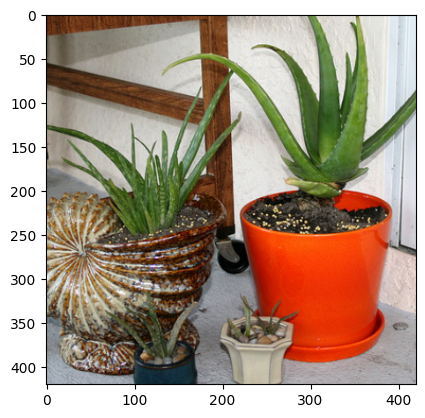

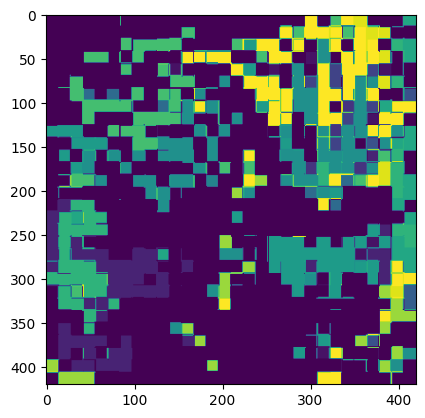

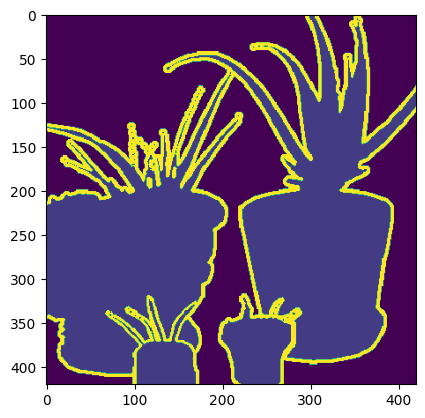

In [109]:
# Test qualitatively the model
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        # y = y.squeeze(1).long()
        y_pred = model(x)
        y_pred = F.softmax(y_pred, dim=1)
        y_pred = torch.argmax(y_pred, dim=1)
        print(y_pred.shape)
        print(y.shape)
        plt.imshow(x[0].cpu().permute(1, 2, 0))
        plt.show()
        plt.imshow(y_pred[0].cpu().numpy())
        plt.show()
        plt.imshow(y[0].squeeze(0).cpu().numpy())
        plt.show()
        break

In [68]:
t = y[0].cpu().numpy()
print(t[t == 0].shape[0] + t[t == 1].shape[0])
print(t.shape[0] * t.shape[1])

176400
176400


# Ideas

- Use metric learning to push toghether embedding of patches/pixels of the same class, in this way, OOD pixels will (hopefully) results in embedding far away from all the other clusters (each clusters represents a class for the segmentation)


In [7]:
import torch
import torch.nn.functional as F


# NT-Xent Loss
def nt_bxent_loss(x, pos_indices, temperature):
    assert len(x.size()) == 2

    # Add indexes of the principal diagonal elements to pos_indices
    pos_indices = torch.cat(
        [
            pos_indices,
            torch.arange(x.size(0)).reshape(x.size(0), 1).expand(-1, 2),
        ],
        dim=0,
    )

    # Ground truth labels
    target = torch.zeros(x.size(0), x.size(0))
    target[pos_indices[:, 0], pos_indices[:, 1]] = 1.0

    # Cosine similarity
    xcs = F.cosine_similarity(x[None, :, :], x[:, None, :], dim=-1)
    # Set logit of diagonal element to "inf" signifying complete
    # correlation. sigmoid(inf) = 1.0 so this will work out nicely
    # when computing the Binary cross-entropy Loss.
    xcs[torch.eye(x.size(0)).bool()] = float("inf")

    # Standard binary cross-entropy loss. We use binary_cross_entropy() here and not
    # binary_cross_entropy_with_logits() because of
    # https://github.com/pytorch/pytorch/issues/102894
    # The method *_with_logits() uses the log-sum-exp-trick, which causes inf and -inf values
    # to result in a NaN result.
    loss = F.binary_cross_entropy(
        (xcs / temperature).sigmoid(), target, reduction="none"
    )

    target_pos = target.bool()
    target_neg = ~target_pos

    loss_pos = torch.zeros(x.size(0), x.size(0)).masked_scatter(
        target_pos, loss[target_pos]
    )
    loss_neg = torch.zeros(x.size(0), x.size(0)).masked_scatter(
        target_neg, loss[target_neg]
    )
    loss_pos = loss_pos.sum(dim=1)
    loss_neg = loss_neg.sum(dim=1)
    num_pos = target.sum(dim=1)
    num_neg = x.size(0) - num_pos

    return ((loss_pos / num_pos) + (loss_neg / num_neg)).mean()


test_labels = torch.randint(0, 10, (224 * 224, 1))
test_labels = test_labels[torch.randperm(len(test_labels))[:400]]
# Flatten the test
test_labels = test_labels.flatten()
print(test_labels)
all_pairs = torch.combinations(torch.arange(test_labels.size(0)), 2)
# Filter the combinations that has the same label
# print(all_pairs)
pos_pairs = all_pairs[test_labels[all_pairs[:, 0]] == test_labels[all_pairs[:, 1]]]
print(len(pos_pairs))

x = torch.randn(400, 512)
temperature = 0.1
nt_bxent_loss(x, pos_pairs, temperature)

tensor([6, 5, 8, 5, 3, 6, 5, 4, 0, 1, 5, 5, 1, 7, 0, 9, 4, 1, 3, 6, 3, 0, 3, 6,
        3, 1, 7, 7, 2, 8, 1, 7, 2, 9, 5, 1, 7, 0, 6, 2, 2, 0, 4, 4, 5, 2, 6, 6,
        5, 7, 0, 3, 1, 4, 5, 1, 7, 5, 3, 9, 6, 2, 8, 3, 0, 8, 9, 4, 4, 9, 6, 9,
        3, 1, 7, 2, 9, 8, 2, 7, 5, 0, 9, 9, 3, 0, 9, 1, 9, 0, 5, 7, 2, 3, 7, 1,
        9, 3, 6, 3, 0, 7, 5, 7, 4, 0, 8, 2, 5, 2, 4, 8, 2, 0, 9, 7, 1, 5, 5, 9,
        0, 5, 5, 2, 4, 1, 3, 1, 7, 6, 2, 3, 4, 2, 3, 5, 9, 1, 0, 6, 1, 9, 8, 9,
        9, 2, 3, 0, 4, 4, 8, 7, 3, 8, 1, 3, 4, 7, 2, 8, 3, 9, 3, 4, 5, 6, 9, 4,
        2, 3, 0, 9, 0, 5, 4, 6, 1, 6, 7, 4, 2, 8, 9, 9, 2, 3, 8, 1, 7, 1, 4, 4,
        9, 5, 8, 4, 0, 3, 4, 0, 7, 1, 2, 1, 4, 6, 7, 6, 2, 2, 1, 4, 6, 8, 1, 3,
        1, 3, 3, 2, 3, 6, 1, 6, 3, 5, 1, 8, 6, 0, 2, 4, 2, 4, 7, 9, 3, 8, 9, 3,
        2, 2, 7, 1, 4, 6, 0, 4, 3, 3, 1, 3, 1, 0, 9, 3, 5, 3, 6, 1, 7, 6, 9, 2,
        5, 9, 9, 3, 8, 2, 8, 9, 0, 8, 2, 9, 4, 5, 2, 0, 7, 0, 6, 0, 3, 5, 3, 5,
        2, 4, 0, 1, 7, 8, 6, 9, 6, 6, 9,

tensor(1.3591)

In [ ]:
# Select a random subset of test_labels